# DSAI Mini-project 
## HDB Resale Price Analysis 

This study aims to develop a regression model to accurately predict HDB resale prices in Singapore by analyzing key factors such as flat type, size, location, and market trends. Beyond price prediction, we will conduct a market analysis to identify shifts in correlations, emerging pricing trends, and external factors influencing the resale market. Our goal is to provide homeowners, buyers, and policymakers with a data-driven tool for better decision-making in the housing market

This file contains the EDA, Data visualisations and ML tasks for our project. For more on the data collection please refer to the dataprep.ipynb file



In [100]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import folium
from folium import Choropleth
import json
from shapely.geometry import shape
from tqdm import tqdm

sns.set_style('darkgrid')

In total, there are 7 datasets that are relevant to our study. 

4 of which are the datasets that we have found online from data.gov regarding the resale price of HDBs. 

3 of which are the datasets we have self collected via webscraping and api calling, which are on hdb, mall and mrt locational data

In [105]:
dfs = [] 
for file in os.listdir('./datasets'):
    if file.endswith('.csv') and 'location' not in file:  # Check if the file is a CSV
        dfs.append(pd.read_csv(f"./datasets/{file}"))

df = pd.concat(dfs, ignore_index=True)  # Ignore index to avoid duplication in the concatenated dataframe
df.head(2)

month        town flat_type block       street_name storey_range  \
0  2000-01  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09   
1  2000-01  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4     04 TO 06   

   floor_area_sqm flat_model  lease_commence_date  resale_price  \
0            69.0   Improved                 1986      147000.0   
1            61.0   Improved                 1986      144000.0   

  remaining_lease  
0             NaN  
1             NaN

In [106]:
hdb_loc_df = pd.read_csv('./datasets/hdb_location.csv')
mall_loc_df = pd.read_csv('./datasets/mall_location.csv')
mrt_loc_df = pd.read_csv('./datasets/mrt_location.csv')

### Exploratory Data Analysis 

### EDA for HDB Resale Dataset
First we will conduct EDA on our hdb resale dataset try to understand what we are working with, as well as see how to clean up our dataset

####  Understanding our data

Here are some summary details and statistics of our dataset

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660656 entries, 0 to 660655
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                660656 non-null  object 
 1   town                 660656 non-null  object 
 2   flat_type            660656 non-null  object 
 3   block                660656 non-null  object 
 4   street_name          660656 non-null  object 
 5   storey_range         660656 non-null  object 
 6   floor_area_sqm       660656 non-null  float64
 7   flat_model           660656 non-null  object 
 8   lease_commence_date  660656 non-null  int64  
 9   resale_price         660656 non-null  float64
 10  remaining_lease      238802 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 55.4+ MB


We see that our dataset consists of a total of 11 columns, and based on research online these are what each of the columns represent


| Feature | Description |
|---------|------------|
| **month** (object) | The month in which the resale transaction took place, formatted as "YYYY-MM". |
| **town** (object) | The town or estate in Singapore where the HDB flat is located (e.g., Ang Mo Kio, Bedok, Jurong West). |
| **flat_type** (object) | The type of HDB flat based on the number of rooms, such as "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", etc. |
| **block** (object) | The block number of the HDB flat. |
| **street_name** (object) | The name of the street where the block is located. |
| **storey_range** (object) | The range of floors where the unit is located, typically in ranges like "01 TO 03", "04 TO 06", etc. |
| **floor_area_sqm** (float64) | The size of the flat in square meters (sqm). |
| **flat_model** (object) | The specific model of the flat (e.g., "Improved", "New Generation", "Model A", "Maisonette"), indicating the design and layout. |
| **lease_commence_date** (int64) | The year when the lease for the flat started. |
| **resale_price** (float64) | The transaction price of the flat in Singapore dollars (SGD). |
| **remaining_lease** (object) | The remaining lease period of the flat at the time of the transaction (e.g., "85 years 2 months"). This column has many missing values, possibly due to it not being recorded for older transactions. |

#### Dataframe Size

In [108]:
df.shape

(660656, 11)

Overall there are up to 660,656 entries in our dataset with 11 columns. 

#### Numerical Features

In [109]:
# Disable scientific notation 
pd.set_option('display.float_format', '{:,.7f}'.format)  # This will show up to 10 decimal places7
df.describe()

floor_area_sqm  lease_commence_date      resale_price
count 660,656.0000000      660,656.0000000   660,656.0000000
mean       96.6914270        1,990.7894986   374,420.5161277
std        25.0038018           11.6739151   174,498.6215847
min        28.0000000        1,966.0000000    28,000.0000000
25%        74.0000000        1,983.0000000   245,000.0000000
50%        95.0000000        1,988.0000000   348,000.0000000
75%       113.0000000        1,999.0000000   465,000.0000000
max       366.7000000        2,021.0000000 1,600,000.0000000

Here we see that:
- Floor area ranges from 28 sqm to 366 sqm, with a mean of 96 sqm. The maximum value is significantly higher than the third quartile (113 sqm), indicating potential outliers. Since larger spaces typically lead to higher prices, this feature will likely be a strong predictor.

- Lease commence date spans from 1966 to 2021, with no apparent outliers, making it a stable quantitative feature.

- Resale price ranges from 28,000 to 1,600,000, with a mean of 374,420. The third quartile is only 465,000, suggesting high-value outliers that could skew the analysis. Careful metric selection is necessary.

#### Categorical variables

In [110]:
df.describe(include='object')

month       town flat_type   block     street_name storey_range  \
count    660656     660656    660656  660656          660656       660656   
unique      303         26         7    2734             578           25   
top     2010-07  WOODLANDS    4 ROOM       2  YISHUN RING RD     04 TO 06   
freq       3679      57365    262762    2726           10767       161899   

       flat_model  remaining_lease  
count      660656           238802  
unique         21              735  
top       Model A               68  
freq       202889             2328

In [111]:
print(f"""
Flat types: {', '.join(df['flat_type'].unique())}'

Flat Storey Range: {', '.join(df['storey_range'].unique())}

Flat Model: {', '.join(df['flat_model'].unique())}

""")


Flat types: 3 ROOM, 4 ROOM, 5 ROOM, EXECUTIVE, 2 ROOM, MULTI-GENERATION, 1 ROOM'

Flat Storey Range: 07 TO 09, 04 TO 06, 01 TO 03, 10 TO 12, 13 TO 15, 16 TO 18, 19 TO 21, 22 TO 24, 25 TO 27, 28 TO 30, 31 TO 33, 40 TO 42, 37 TO 39, 34 TO 36, 46 TO 48, 43 TO 45, 49 TO 51, 06 TO 10, 01 TO 05, 11 TO 15, 16 TO 20, 21 TO 25, 26 TO 30, 36 TO 40, 31 TO 35

Flat Model: Improved, New Generation, Model A, Standard, Apartment, Simplified, Model A-Maisonette, Maisonette, Multi Generation, Adjoined flat, Premium Apartment, Terrace, Improved-Maisonette, Premium Maisonette, 2-room, Model A2, Type S1, Type S2, DBSS, Premium Apartment Loft, 3Gen




As for the categorical variables, we see that 
- Month has 303 unique values, seemingly containing both month and year. The most frequent value is July 2010, indicating the highest resale activity.

- Town includes 26 towns, with Woodlands having the most resales, which could be important as prices vary by region.

- Flat type consists of 7 categories and should be treated as ordinal, as more rooms generally indicate higher prices.

- Housing block has 2,734 unique values, likely unrelated to resale price and a candidate for removal.

- Street names (578 unique) could introduce noise but may be useful for feature engineering (e.g., distance to MRT).

- Storey range is given in intervals (e.g., 04-06 being most common). We could use the midpoint or split it into upper/lower values.

- Flat model has 21 types but lacks a clear hierarchy; further analysis is needed to assess relevance.

- Remaining lease has 735 unique values, which is unexpected given Singapore’s 99-year lease policy and warrants closer inspection.

#### Split month and year 

The month column in the dataframe is the month in which the resale transaction took place. However as it contains a mix of both the month and year, it is not very useful as it is. Hence, we decided to split it into different individual columns (year_recorded, month_recorded) for further analysis, which would be used later in this project.

In [112]:
df['year_recorded']  = df['month'].apply(lambda x: x.split('-')[0]).astype("int64")
df['month_recorded'] = df['month'].apply(lambda x: x.split('-')[1]).astype("int64")
df.drop(['month'], axis=1, inplace=True)
df.head()

town flat_type block       street_name storey_range  floor_area_sqm  \
0  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09      69.0000000   
1  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4     04 TO 06      61.0000000   
2  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     07 TO 09      73.0000000   
3  ANG MO KIO    3 ROOM   215  ANG MO KIO AVE 1     07 TO 09      73.0000000   
4  ANG MO KIO    3 ROOM   218  ANG MO KIO AVE 1     07 TO 09      67.0000000   

       flat_model  lease_commence_date    resale_price remaining_lease  \
0        Improved                 1986 147,000.0000000             NaN   
1        Improved                 1986 144,000.0000000             NaN   
2  New Generation                 1976 159,000.0000000             NaN   
3  New Generation                 1976 167,000.0000000             NaN   
4  New Generation                 1976 163,000.0000000             NaN   

   year_recorded  month_recorded  
0           2000               1  
1           2000               1  
2           2000               1  
3           2000               1  
4           2000               1

#### Check for Null values

Next, we check if there are any null or missing values in our dataset that we may need to handle.

In [113]:
missing_values = df.isnull().sum()
missing_values

town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        421854
year_recorded               0
month_recorded              0
dtype: int64

Generally, we can see that our dataset has no null values for most columns except for the column `remaining_lease`. However, it will not be an issue as we will be able to calculate the remaining lease by using the formula: `99 - (year_recorded - lease_commence_date)`.

Where 99 is the max starting lease that all Singapore HDBs have. But before overwriting, let's take a look at the `remaining_lease` to see if there are any significant details that we need to take note of.

In [114]:
df_with_rl = df[df['remaining_lease'].notnull()]
df_with_rl['remaining_lease']

369651                    70
369652                    65
369653                    64
369654                    63
369655                    64
                 ...        
660651    66 years 04 months
660652    61 years 08 months
660653    62 years 07 months
660654    89 years 10 months
660655    62 years 06 months
Name: remaining_lease, Length: 238802, dtype: object

Looking at the info of `df_with_rl['remaining_lease']`, we identified that there is a mix of data inside our `remaining_lease` column, where some of the rows only have a year value while the others have a year and month string. To determine what to do with this, we decided to check if the years provided from the dataset matches the calculation of `99 - (year_recorded - lease_commence_date)`

In [115]:
df_with_rl = df_with_rl.copy()
df_with_rl['check_remaining_lease'] = 99 - (df_with_rl['year_recorded'].astype('int64') - df_with_rl['lease_commence_date'].astype('int64'))
df_with_rl.iloc[0:2]

town flat_type block        street_name storey_range  \
369651  ANG MO KIO    3 ROOM   174   ANG MO KIO AVE 4     07 TO 09   
369652  ANG MO KIO    3 ROOM   541  ANG MO KIO AVE 10     01 TO 03   

        floor_area_sqm      flat_model  lease_commence_date    resale_price  \
369651      60.0000000        Improved                 1986 255,000.0000000   
369652      68.0000000  New Generation                 1981 275,000.0000000   

       remaining_lease  year_recorded  month_recorded  check_remaining_lease  
369651              70           2015               1                     70  
369652              65           2015               1                     65

From the above dataframe (`df_with_rl`) we see that the `check_remaining_lease` column values matches with the `remaining_lease` column. 


#### Overwritting remaining lease
For the rows that contains month in the `remaining_lease` column, we have no choice but to remove the month detail to ensure standardisation for all rows, as we are not able to get the months for all the rows. 

To do this, we will just overwrite the entire column in our main dataset

In [116]:
df = df.copy()
df['remaining_lease'] = 99 - (df['year_recorded'].astype('int64') - df['lease_commence_date'].astype('int64'))
df.head()

town flat_type block       street_name storey_range  floor_area_sqm  \
0  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09      69.0000000   
1  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4     04 TO 06      61.0000000   
2  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     07 TO 09      73.0000000   
3  ANG MO KIO    3 ROOM   215  ANG MO KIO AVE 1     07 TO 09      73.0000000   
4  ANG MO KIO    3 ROOM   218  ANG MO KIO AVE 1     07 TO 09      67.0000000   

       flat_model  lease_commence_date    resale_price  remaining_lease  \
0        Improved                 1986 147,000.0000000               85   
1        Improved                 1986 144,000.0000000               85   
2  New Generation                 1976 159,000.0000000               75   
3  New Generation                 1976 167,000.0000000               75   
4  New Generation                 1976 163,000.0000000               75   

   year_recorded  month_recorded  
0           2000               1  
1           2000               1  
2           2000               1  
3           2000               1  
4           2000               1

#### Check for duplicates

We will also need to check for duplicates in our dataset

In [117]:
duplicate_rows_df = df[df.duplicated(keep=False)]
duplicate_rows_df.shape

(2312, 12)

We see that there are 2312 duplicate rows in our dataset, however we decided that we could actually keep the duplicates as they could just be people in the same block selling at the same price. This is due to how residents will usually check what others (maybe neighbors) living in the same blk are selling at.

#### Skewness and Outlier Testing

The next essential part of understanding is checking the skewness and outliers of all of our numerical columns. This will give us a better understanding on what is happening and what to do next. 

However we are going to separate them in terms of predictor and target variables 

##### Predictor variables

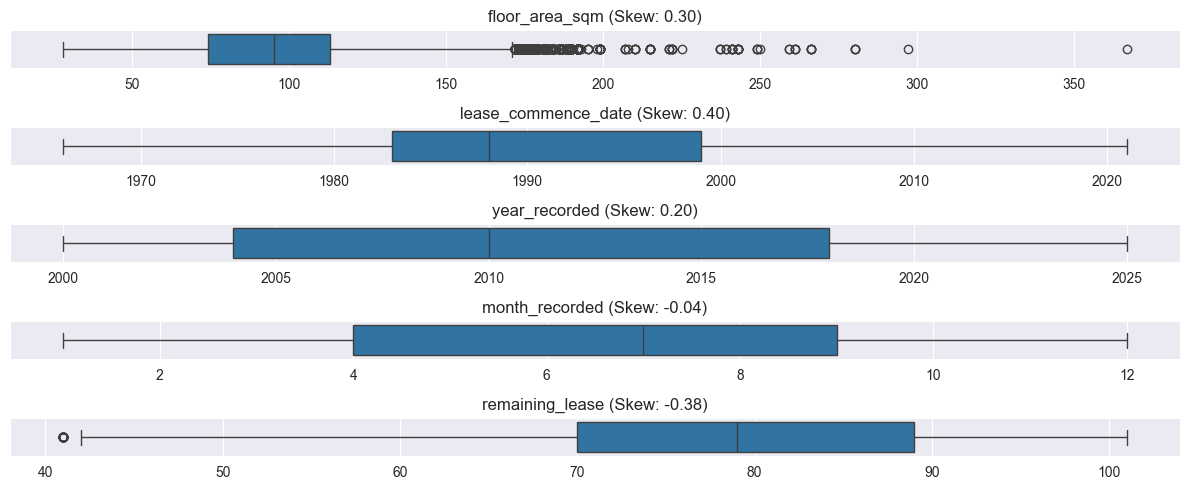

In [118]:

# Define numerical columns
numerical_cols = ['floor_area_sqm', 'lease_commence_date', 'year_recorded', 'month_recorded', 'remaining_lease']

fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(12, 5), sharey=False)

# Generate horizontal boxplots for each feature with skewness in the title
for i, col in enumerate(numerical_cols):
    skewness = df[col].skew()  # Calculate skewness using pandas
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"{col} (Skew: {skewness:.2f})")  # Add skewness to title
    axes[i].set_xlabel("")  # Remove x-axis label for cleaner visualization

plt.tight_layout()  
plt.show()

In the graph above, we generated box plots for all our numerical predictor features. We have also calculated and labeled their respective skewness scores to their titles. From which we observe that: 
- floor area contains quite a few outliers with some even reaching > 350 sqm. However these may not be uncommon as houses usually do contain one or 2 that are quite significant in size. Its moderate positive skew is also unsuprising, as more houses tend to be smaller

- The positive skew suggests that most resales occurred in the earlier years, specifically between 2000 and 2015. This could be due to the data for 2025 only covering up to March, causing the later years to be underrepresented.

- Both year and month do not have outliers, indicating consistent and accurate data with no erroneous values.

- Finally remaining lease is the most interesting! We see a moderate negative skew,  This suggests that most resales happen in the first 30 years of a HDB's lease. As the HDB ages past 30 years, fewer units are resold, likely due to the decreasing remaining lease and potentially less desirable units for buyers.


Based on the results above thereis little to no need to handle the outliers as they appear to be valid 

##### Sale Price 

Next we will look at the distribution for the target feature

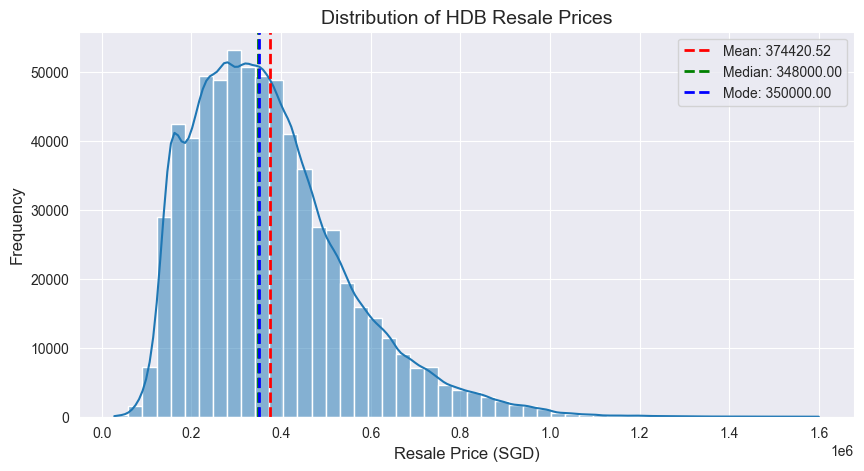

In [119]:
mean_price = df["resale_price"].mean()
median_price = df["resale_price"].median()
mode_price = df["resale_price"].mode()[0]  # Mode can return multiple values, take first

# Create histogram
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="resale_price", bins=50, kde=True)

# Plot vertical lines for mean, median, mode
plt.axvline(mean_price, color="red", linestyle="dashed", linewidth=2, label=f"Mean: {mean_price:.2f}")
plt.axvline(median_price, color="green", linestyle="dashed", linewidth=2, label=f"Median: {median_price:.2f}")
plt.axvline(mode_price, color="blue", linestyle="dashed", linewidth=2, label=f"Mode: {mode_price:.2f}")

# Titles & Labels
plt.title("Distribution of HDB Resale Prices", fontsize=14)
plt.xlabel("Resale Price (SGD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

In [141]:
print(f"Skewness score: {df['resale_price'].skew()}")

Skewness score: 1.0570945219718373


The histogram shows a positive skew in resale prices, with a skewness score of 1.05, indicating a few high values pulling the mean to the right. This skewness can affect model performance, especially for models like linear regression that assume normal distribution of the target variable.

Skewed data can also distort visualizations like correlation plots causing misinterpretation. To address this, we can apply a logarithmic transformation to reduce the skewness. Additionally, models less sensitive to outliers, like Lasso or Ridge regression, can be considered.

In [142]:
df['log_resale_price'] = np.log(df['resale_price'])
df.head(1)

town flat_type block       street_name storey_range  floor_area_sqm  \
0  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09      69.0000000   

  flat_model  lease_commence_date    resale_price  remaining_lease  \
0   Improved                 1986 147,000.0000000               85   

   year_recorded  month_recorded                         address  \
0           2000               1  170 ANG MO KIO AVE 4 SINGAPORE   

   log_resale_price  
0        11.8981879

By logging we are effectively re representing it as a proportion, allowing us to see the true correlation between 2 features

#### EDA for Mall, MRT and HDB location dataset

Next we will also do some EDA for our Mall, MRT and HDB location dataset

In [143]:
print(mall_loc_df.columns)
print(mrt_loc_df.columns)
print(hdb_loc_df.columns)

Index(['mall', 'building', 'latitude', 'longitude', 'outlier'], dtype='object')
Index(['mrt', 'building', 'latitude', 'longitude', 'code', 'outlier'], dtype='object')
Index(['hdb', 'latitude', 'longitude', 'outlier', 'dist_mrt', 'near_mrt',
       'dist_mall', 'near_mall'],
      dtype='object')


In our 3 location related datasets, we see that wer generally have the name of place and lat/long data

#### Check datatypes
We will also do a quick check on the datasets datatypes

In [144]:
mall_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 0 to 173
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mall       172 non-null    object 
 1   building   172 non-null    object 
 2   latitude   172 non-null    float64
 3   longitude  172 non-null    float64
 4   outlier    172 non-null    bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 6.9+ KB


In [145]:
mrt_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 0 to 182
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mrt        183 non-null    object 
 1   building   183 non-null    object 
 2   latitude   183 non-null    float64
 3   longitude  183 non-null    float64
 4   code       183 non-null    object 
 5   outlier    183 non-null    bool   
dtypes: bool(1), float64(2), object(3)
memory usage: 8.8+ KB


In [146]:
hdb_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hdb        9838 non-null   object 
 1   latitude   9838 non-null   float64
 2   longitude  9838 non-null   float64
 3   outlier    9838 non-null   bool   
 4   dist_mrt   9838 non-null   float64
 5   near_mrt   9838 non-null   object 
 6   dist_mall  9838 non-null   float64
 7   near_mall  9838 non-null   object 
dtypes: bool(1), float64(4), object(3)
memory usage: 547.8+ KB


For all 3 of the locational datasets, we see that all of the data types are inorder, with 
- lat and long being float64s 
- hdb, mrt, building and mall being object dtypes

#### Dataset Size 

In [147]:
print("mall", mall_loc_df.shape)
print("mrt", mrt_loc_df.shape)
print("hdb", hdb_loc_df.shape)

mall (172, 5)
mrt (183, 6)
hdb (9838, 8)


From the size, we see that we have info of 
- 174 different mall locations
- 186 different mrt locations
- 9838 different hdb locations

#### Check for null values

In [148]:
print('Mall\n-------------------\n'+ str(mall_loc_df.isnull().sum()))
print('MRT\n-------------------\n'+ str(mrt_loc_df.isnull().sum()))
print('HDB\n-------------------\n'+ str(hdb_loc_df.isnull().sum()))

Mall
-------------------
mall         0
building     0
latitude     0
longitude    0
outlier      0
dtype: int64
MRT
-------------------
mrt          0
building     0
latitude     0
longitude    0
code         0
outlier      0
dtype: int64
HDB
-------------------
hdb          0
latitude     0
longitude    0
outlier      0
dist_mrt     0
near_mrt     0
dist_mall    0
near_mall    0
dtype: int64


We see that all of them do not have any null value, which is good

#### Check for outliers
We should also check for outliers in our lat and long data, ensuring that our geolocation values are all within regions of Singapore. Here we created a function that will plot a scatterplot with SG's boundaries as a bounding box

In [149]:
def check_sg_geo_outliers(df, ax, title="Untitled Graph"):
    lat_min, lat_max = 1.130, 1.480
    long_min, long_max = 103.610, 104.080

    # Identify outliers
    df['outlier'] = ((df['latitude'] < lat_min) | (df['latitude'] > lat_max) |
                    (df['longitude'] < long_min) | (df['longitude'] > long_max))

    # For plotting
    outliers = df[df['outlier'] == True]
    valid_points = df[df['outlier'] == False]
    
    ax.scatter(data=valid_points, x='longitude', y='latitude', color='blue', label='Valid Points')
    ax.scatter(data=outliers, x='longitude', y='latitude', color='red', label='Outliers')

    # Plot Singapore boundary box
    ax.axhline(lat_min, color='gray', linestyle='dashed')
    ax.axhline(lat_max, color='gray', linestyle='dashed')
    ax.axvline(long_min, color='gray', linestyle='dashed')
    ax.axvline(long_max, color='gray', linestyle='dashed')

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(title)
    ax.legend()


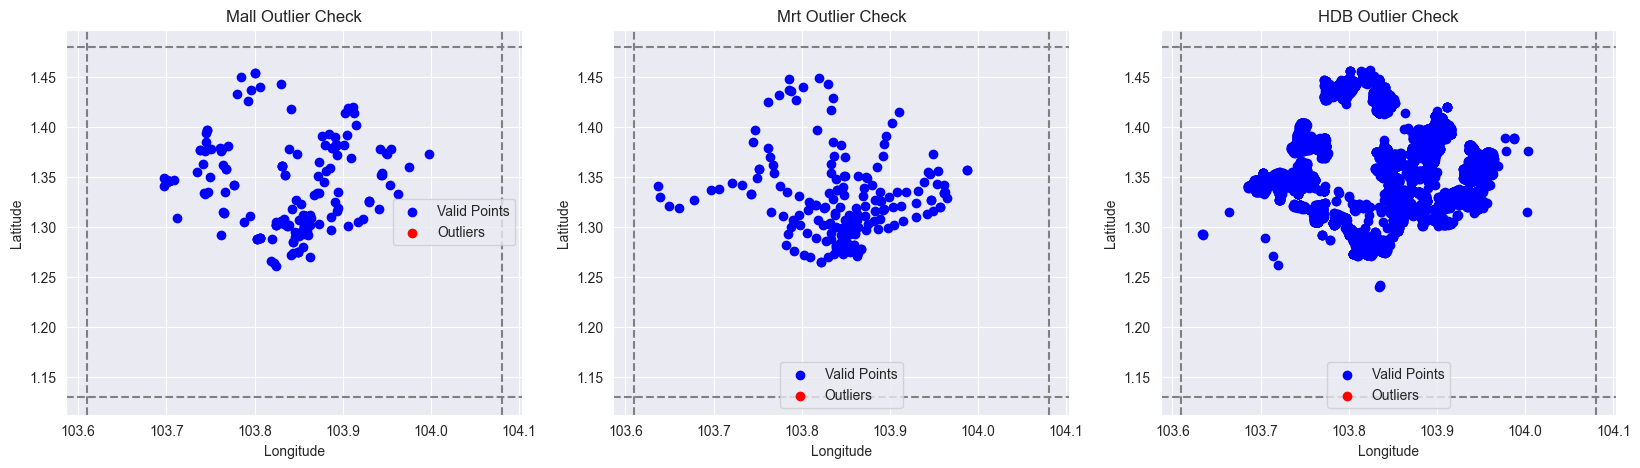

In [128]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
check_sg_geo_outliers(mall_loc_df, ax1, title="Mall Outlier Check")
check_sg_geo_outliers(mrt_loc_df, ax2,  title="Mrt Outlier Check")
check_sg_geo_outliers(hdb_loc_df, ax3, title="HDB Outlier Check")

From the plot above, we see that there are completely no outliers in our locational data for mall, mrt and hdbs, hence no action must be taken.

#### Check for duplicates
We will also check for duplicates in the location datasets

In [129]:
duplicate_rows_df = mrt_loc_df[mrt_loc_df.duplicated()]
print('MRT', duplicate_rows_df.shape)

duplicate_rows_df = mall_loc_df[mall_loc_df.duplicated()]
print('Mall', duplicate_rows_df.shape)

duplicate_rows_df = hdb_loc_df[hdb_loc_df.duplicated()]
print('HDB', duplicate_rows_df.shape)

MRT (3, 6)
Mall (2, 5)
HDB (0, 4)


Here we see that there are 3 duplicates for MRT and 2 duplicates for Mall, while HDB has no duplicate rows. Since this is just locational data, we can simply just drop them 

In [130]:
mrt_loc_df.drop_duplicates(inplace=True)
mall_loc_df.drop_duplicates(inplace=True)
print('MRT', mrt_loc_df.shape)
print('Mall', mall_loc_df.shape)


MRT (183, 6)
Mall (172, 5)


#### Distance between HDB - Mall and MRT

We can calculate the distance to the nearest MRT station or mall for each home using the coordinates from earlier. Our hypothesis is that proximity to these amenities will affect resale prices, as greater convenience increases demand. To do this, we'll use geopy's great-circle tool to compute the distance between points based on latitude and longitude.

<img src='https://www.caliper.com/glossary/xmaptitude-great-circle-map.jpg.pagespeed.ic.he9JED27BN.webp'></img>

In [131]:
from geopy.distance import great_circle

address =[]
d_mrt = []
n_mrt = []
d_mall = []
n_mall = []

for add,lat,lon in tqdm(zip(hdb_loc_df.hdb,hdb_loc_df.latitude,hdb_loc_df.longitude), desc="Fetching Nearest Ammenities"):
    d_to_mrt = 99
    d_to_mall = 99
    temp = 0
    
    #loop for MRT and Mall to find the shortest distance to address
    for mrt,mrt_lat,mrt_lon in zip(mrt_loc_df.building, mrt_loc_df.latitude, mrt_loc_df.longitude):
        temp = great_circle((lat, lon), (mrt_lat, mrt_lon)).km
        if d_to_mrt > temp:
            d_to_mrt = temp
            n_to_mrt = mrt
    for mall,mall_lat,mall_lon in zip(mall_loc_df.mall, mall_loc_df.latitude, mall_loc_df.longitude):
        temp = great_circle((lat, lon), (mall_lat, mall_lon)).km
        if d_to_mall > temp:
            d_to_mall = temp  
            n_to_mall = mall
    
    address.append(add)
    d_mrt.append(d_to_mrt)
    n_mrt.append(n_to_mrt)
    d_mall.append(d_to_mall)
    n_mall.append(n_to_mall)
    
hdb_loc_df['dist_mrt'] = d_mrt
hdb_loc_df['near_mrt'] = n_mrt
hdb_loc_df['dist_mall'] = d_mall
hdb_loc_df['near_mall'] = n_mall

Fetching Nearest Ammenities: 9838it [01:18, 126.13it/s]


In [150]:
df['address'] = df['block'] + ' ' + df['street_name'] + ' '+ 'SINGAPORE'
merged_df = pd.merge(df, hdb_loc_df, how='left', left_on='address', right_on='hdb')
# Drop the redundant 'hdb' column if needed
merged_df.drop(columns=['hdb'], inplace=True)
merged_df.head(2)

town flat_type block       street_name storey_range  floor_area_sqm  \
0  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09      69.0000000   
1  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4     04 TO 06      61.0000000   

  flat_model  lease_commence_date    resale_price  remaining_lease  ...  \
0   Improved                 1986 147,000.0000000               85  ...   
1   Improved                 1986 144,000.0000000               85  ...   

   month_recorded                         address log_resale_price  latitude  \
0               1  170 ANG MO KIO AVE 4 SINGAPORE       11.8981879 1.3791499   
1               1  174 ANG MO KIO AVE 4 SINGAPORE       11.8775686 1.3791499   

    longitude  outlier  dist_mrt                         near_mrt dist_mall  \
0 103.8409382    False 0.5315847  YIO CHU KANG MRT STATION (NS15) 0.2604689   
1 103.8409382    False 0.5315847  YIO CHU KANG MRT STATION (NS15) 0.2604689   

   near_mall  
0    AMK Hub  
1    AMK Hub  

[2 rows x 21 columns]

#### Extract middle, upper and lower bounds of storey range 
Another column that needs handling would be the storey range feature, which indicates the lower and upper bound range that each house is in. Initially we thought that the house storeys would be in consistent intervals of 3 levels like 07 to 09, but there see to be some with larger ranges like 06 to 10.  

In [151]:
merged_df['storey_range'].unique()

array(['07 TO 09', '04 TO 06', '01 TO 03', '10 TO 12', '13 TO 15',
       '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30',
       '31 TO 33', '40 TO 42', '37 TO 39', '34 TO 36', '46 TO 48',
       '43 TO 45', '49 TO 51', '06 TO 10', '01 TO 05', '11 TO 15',
       '16 TO 20', '21 TO 25', '26 TO 30', '36 TO 40', '31 TO 35'],
      dtype=object)

So we have decided to extract the upper, lower and middle of the stories for each range. Upper and lower will be used for ML as it retains information that is more pure, but the middle will only be used for visualisation as it is easier to analyse

In [152]:
# Extract the lower and upper bounds using regex (faster than apply)
merged_df[['storey_lower', 'storey_upper']] = merged_df['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(int)

# Compute the middle storey in a vectorized way
merged_df['storey_middle'] = (merged_df['storey_lower'] + merged_df['storey_upper']) // 2
merged_df.drop(['storey_range'], axis=1, inplace=True)
# Display the updated DataFrame
merged_df.head(2)


town flat_type block       street_name  floor_area_sqm flat_model  \
0  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4      69.0000000   Improved   
1  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4      61.0000000   Improved   

   lease_commence_date    resale_price  remaining_lease  year_recorded  ...  \
0                 1986 147,000.0000000               85           2000  ...   
1                 1986 144,000.0000000               85           2000  ...   

   latitude   longitude  outlier  dist_mrt                         near_mrt  \
0 1.3791499 103.8409382    False 0.5315847  YIO CHU KANG MRT STATION (NS15)   
1 1.3791499 103.8409382    False 0.5315847  YIO CHU KANG MRT STATION (NS15)   

   dist_mall  near_mall storey_lower  storey_upper storey_middle  
0  0.2604689    AMK Hub            7             9             8  
1  0.2604689    AMK Hub            4             6             5  

[2 rows x 23 columns]

In [153]:
merged_df.columns

Index(['town', 'flat_type', 'block', 'street_name', 'floor_area_sqm',
       'flat_model', 'lease_commence_date', 'resale_price', 'remaining_lease',
       'year_recorded', 'month_recorded', 'address', 'log_resale_price',
       'latitude', 'longitude', 'outlier', 'dist_mrt', 'near_mrt', 'dist_mall',
       'near_mall', 'storey_lower', 'storey_upper', 'storey_middle'],
      dtype='object')

In [154]:
merged_df.to_csv('./datasets/merged_df.csv')

### Data Visualization

#### Resale Price vs Flat Type and Resale Price vs Flat Model


Firstly, We wanted to explore the relationship between resale price and flat attributes like type and model. 

Our hypothesis was that flat type would show a clear pricing pattern (more rooms = higher price), while flat model would be more inconsistent, as it relates to internal design rather than room count. To test this, we used box plots.

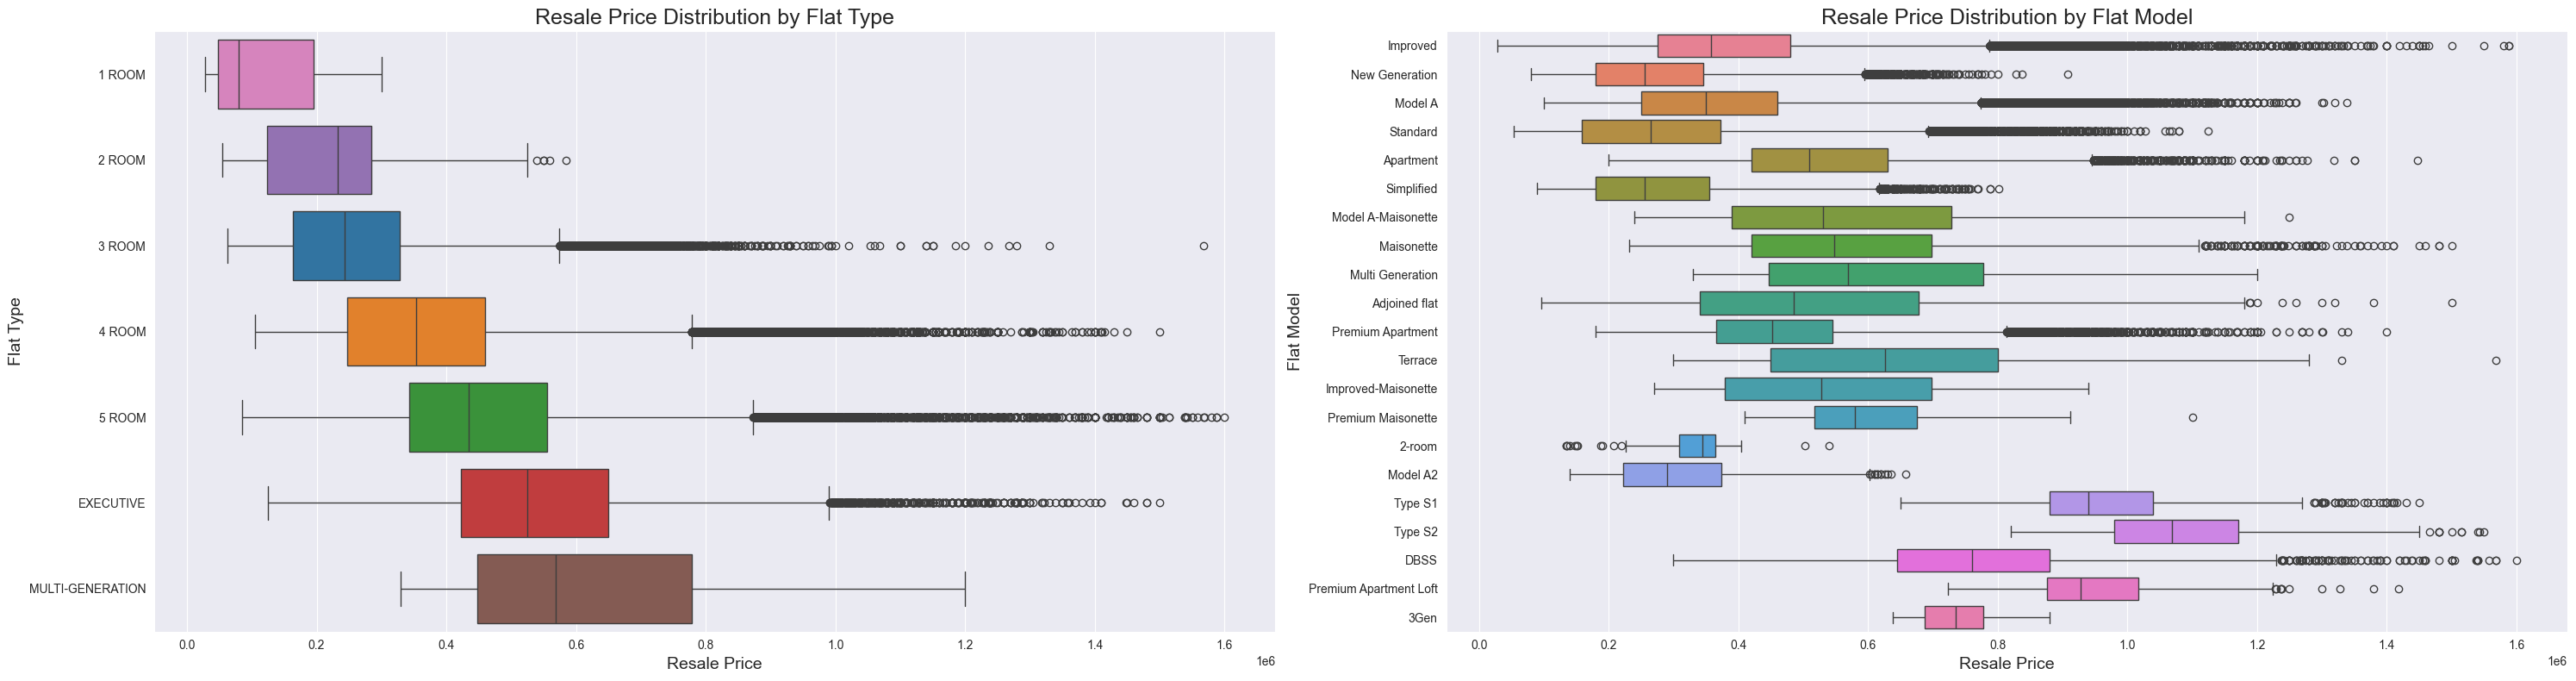

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))

ordered_flat_types = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

# Boxplot for resale price by flat type
sns.boxplot(data=merged_df, x='resale_price', y='flat_type', hue='flat_type', order=ordered_flat_types, ax=ax1)
ax1.set_title('Resale Price Distribution by Flat Type', fontsize=18)
ax1.set_xlabel('Resale Price', fontsize=14)
ax1.set_ylabel('Flat Type', fontsize=14)

# Boxplot for resale price by flat model
sns.boxplot(data=merged_df, x='resale_price', y='flat_model', hue='flat_model', ax=ax2)
ax2.set_title('Resale Price Distribution by Flat Model', fontsize=18)
ax2.set_xlabel('Resale Price', fontsize=14)
ax2.set_ylabel('Flat Model', fontsize=14)

plt.tight_layout()
plt.show()

From the results, we observe that:

- Resale price and flat type show a clear positive correlation, with prices rising as the number of rooms increases. The third quartile (Q3) also increases with room count, indicating higher prices for larger flats, despite some outliers.
- Flat model shows less clear trends, with significant overlap in price ranges. However, we see that prices for Type S1, S2, DBSS, Premium Apartment Loft, and 3Gen homes are notably higher than other models.

Research reveals that:
- Type S1 and S2 are from The Pinnacle, an expensive HDB project.
- DBSS Flats are private-design, exclusive homes.
- Premium Apartment Lofts are 2-story HDBs with large living areas.
- 3Gen housing caters to multi-generational families with larger living spaces.

These factors explain the price differences linked to these specific flat models as they are the more premium selections provided for resale

#### Correlational Analysis

Next we wanted to take a look at the correlations between different features in our dataset and the resale price

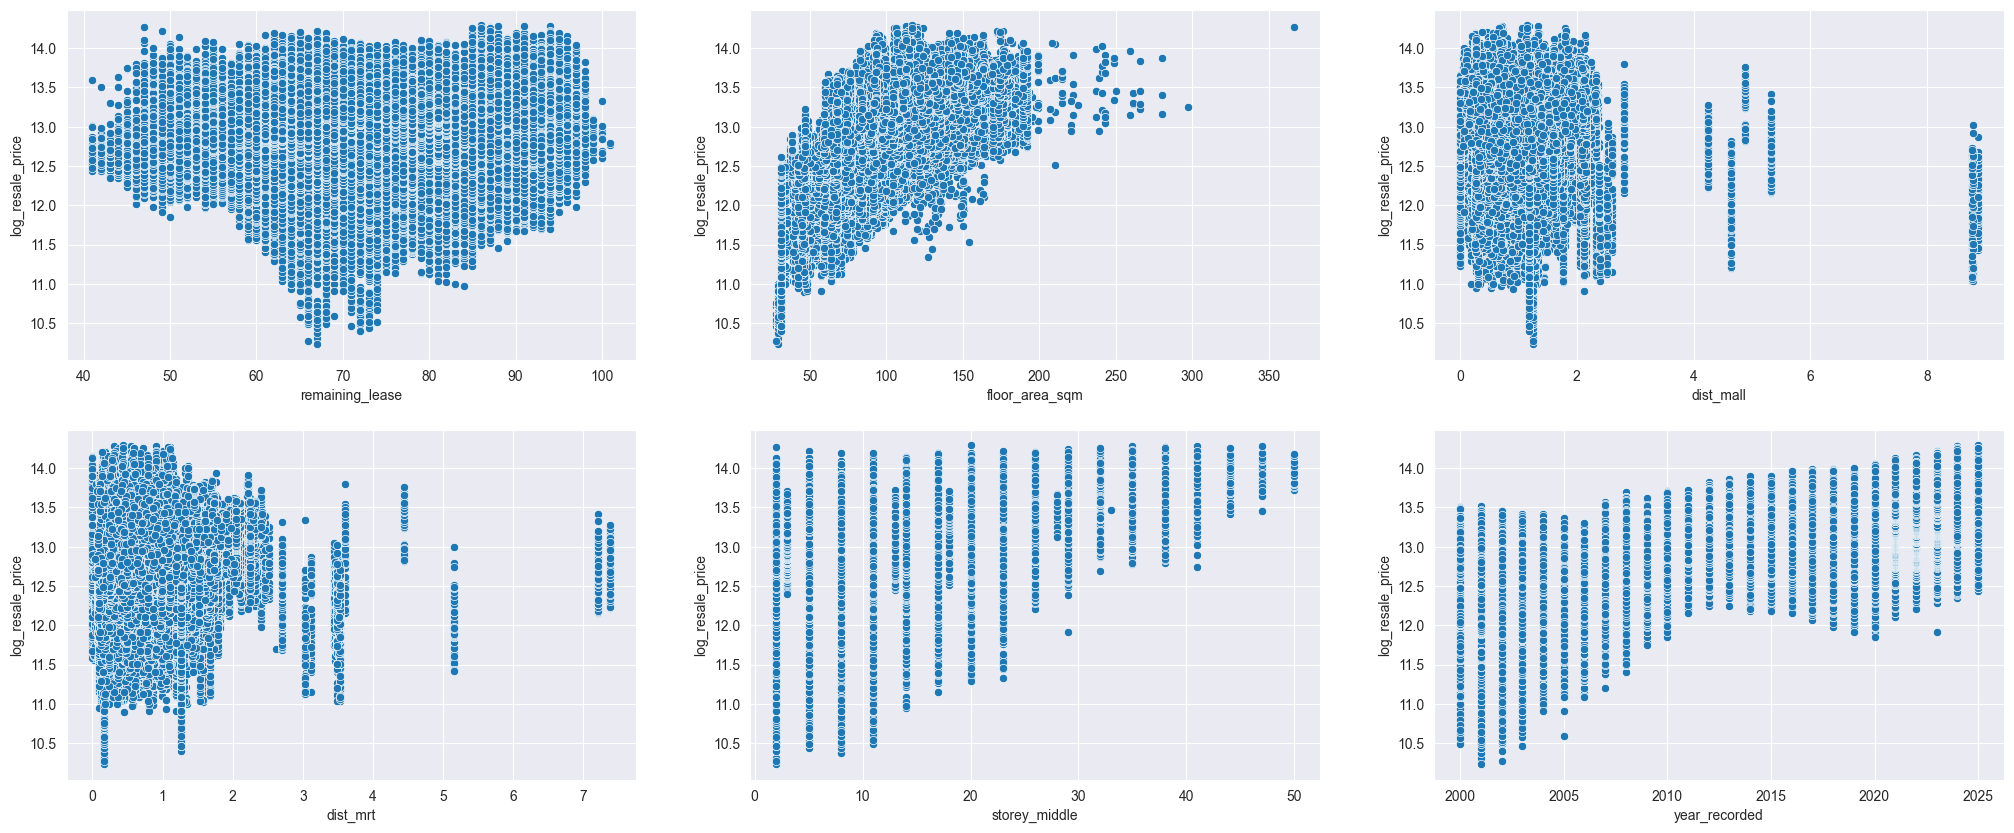

In [156]:
fig, ((ax1,ax2,ax3),(ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(25, 10))
num_ds = merged_df[['remaining_lease', 'floor_area_sqm', 'dist_mall', 'dist_mrt' , 'storey_middle','log_resale_price', 'year_recorded']]

# Create the scatter plot within the subplot

sns.scatterplot(data = num_ds, x='remaining_lease', y='log_resale_price', ax=ax1)
sns.scatterplot(data = num_ds, x='floor_area_sqm', y='log_resale_price', ax=ax2)
sns.scatterplot(data = num_ds, x='dist_mall', y='log_resale_price', ax=ax3)
sns.scatterplot(data = num_ds, x='dist_mrt', y='log_resale_price', ax=ax4)
sns.scatterplot(data = num_ds, x='storey_middle', y='log_resale_price', ax=ax5)
sns.scatterplot(data = num_ds, x='year_recorded', y='log_resale_price', ax=ax6)

# Show the plot
plt.show()

Based on the scatter plots above, we can infer that
- There seems to be little to no general correlation between resale price and remaining lease.

- There is a moderately positive correlation between floor area and resale price which is not suprising as it indicates that bigger homes in general would be more expensive

- The correlation between the distance to the nearest mrt and distance to nearest mall is not so clear cut, however we do see that a lot of homes are wihin 0 to 3 km away from them, higlighting Singapores interconnectedness and convenience of ammenities

- There is a slight positive correlation between the resale price and the storey range, indicating that there is definitely an increase in premium as the storey increases, however we also see that homes of any storey can take on a plathora of price ranges hence weakening the overall correlation.

- Finally it is clear that the year recorded has a positive correlation with the resale price, and this makes sense as well due to gradual market inflation. 

However after observing the inflationary effect of the economy through the positive correlation year has with resale price, one can't help but think that maybe the year adds noise to the other house factors, hence hiding their true correlational value

To test this we decided to do a year seperated heat map for all of the numerical features

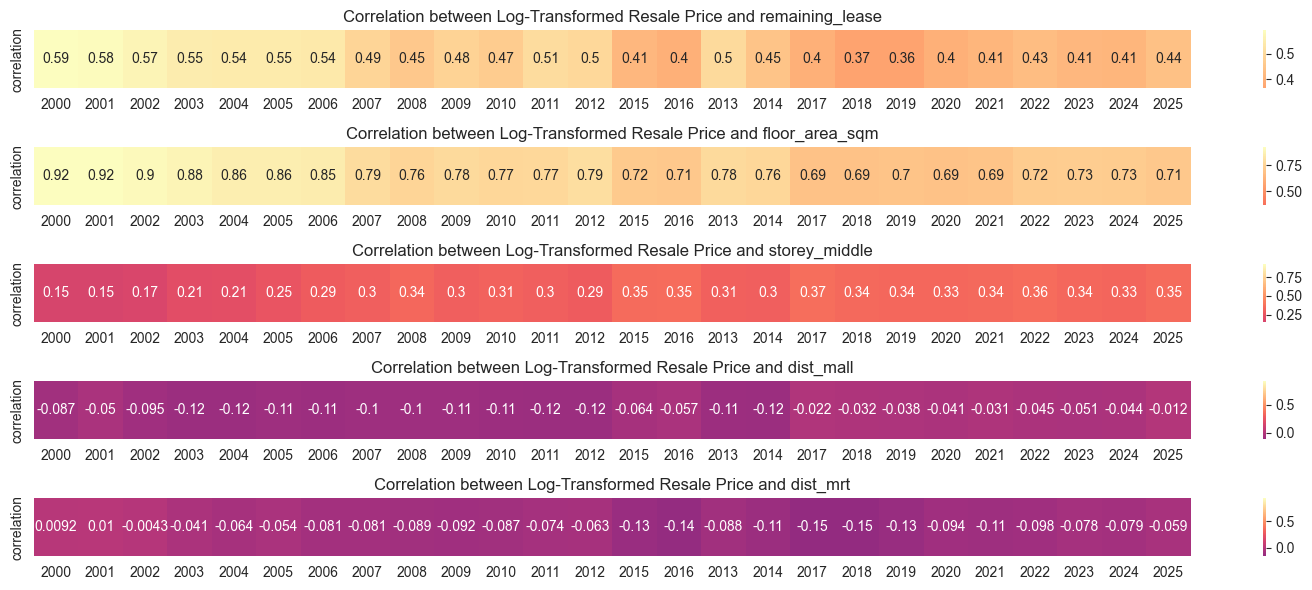

In [157]:
variables = ['remaining_lease', 'floor_area_sqm', 'storey_middle', 'dist_mall', 'dist_mrt']
fig, axes = plt.subplots(5, 1, figsize=(15, 6))
all_corr_vals = []

# Loop through each variable to generate heatmaps
for idx, var in enumerate(variables):
    heat = pd.DataFrame({'correlation': []})
    
    # Loop through each unique year and calculate the correlation
    for year in merged_df['year_recorded'].unique():
        year_df = merged_df[merged_df['year_recorded'] == year].copy()
        corr_val = year_df[['log_resale_price', var]].corr().iloc[0, 1]
        heat.loc[year] = corr_val  
    all_corr_vals.append(heat['correlation'])
    # Plot heatmap for the current variable
    sns.heatmap(heat.T, annot=True, center=0, ax=axes[idx], cmap='magma', vmin=np.min(all_corr_vals), vmax=np.max(all_corr_vals))

    axes[idx].set_title(f"Correlation between Log-Transformed Resale Price and {var}")

plt.tight_layout()
plt.show()


Based on the heatmaps, we observe the following:

- **Resale price vs remaining lease:** A moderately positive correlation (r=0.5) suggests that remaining lease significantly impacts resale price. The correlation weakens over time, reflecting a market shift from 2000 to 2025.
  
- **Resale price vs floor area (sqm):** A strong positive correlation of (r=0.9) indicates that larger flats are more expensive. However, this correlation has also weakened over time, suggesting market changes.

- **Resale price vs storey range:** Initially weak, the correlation has strengthened, showing that storey range has become more important in determining resale price.

- **Distance to MRT and mall:** Little to no correlation with resale price, but there may still be a non-linear relationship. We will test its usefulness in model training later.

In conclusion, we identified features that influence resale price and observed the impact of market shifts. This highlights the importance of regularly retraining models for accurate predictions.

### GeoSpatial Regional Analysis of HDB and Resale Price
Since we gathered extensive data on Singapore's MRTs, malls, and HDB locations, it would be interesting to perform a geospatial analysis of how different features relate to resale prices in various regions of Singapore. 

For the analysis below, we selected the most insightful analyses. 

However, preparation was essential, involving multiple feature aggregates like median resale price, number of resales, mall and MRT distances, and the correlation between floor area and resale price. Not all data was used in the final analysis.

In [158]:
# Get aggregate data
town_agg_df = merged_df.groupby('town').agg(
    median_resale_price=('resale_price', 'median'),
    count_resale_price=('resale_price', 'count'),
    dist_mrt=('dist_mrt', 'mean'),
    dist_mall=('dist_mall', 'mean'),
    lease_commence_date=('lease_commence_date', 'mean'),
    floor_area=('floor_area_sqm', 'median')
).reset_index()

# Fix some null values
town_agg_df.loc[town_agg_df['town'] == 'KALLANG/WHAMPOA', 'town'] = 'KALLANG'
town_agg_df.loc[town_agg_df['town'] == 'CENTRAL AREA', 'town'] = 'DOWNTOWN CORE'

# Rename to fit geo json identifiers
town_agg_df['planning_area'] = town_agg_df['town'].apply(lambda x: x.title())
with open('./datasets/district_and_planning_area.geojson') as f:
    geojson_data = json.load(f)

# Merge geo json district properties
district_dict = {}
l = []
for i in geojson_data['features']:
    district_dict[i['properties']['planning_area']] = i['properties']['district']

# Fill Na central cuz tested before the there are 2 areas from central with NaN
town_agg_df['district'] = town_agg_df['planning_area'].map(district_dict).fillna('Central')
corr_df = pd.DataFrame({
    'town': [],
    'corr_resale_commence': []
})

# Calculte correlation individually for each town
for town in merged_df['town'].unique():
    town_data = merged_df[merged_df['town'] == town]
    corr_value =town_data[['log_resale_price', 'floor_area_sqm']].corr().iloc[0,1]
    new = pd.DataFrame({
        'town': [town],
        'corr_resale_commence': [corr_value]
    })

    corr_df = pd.concat([corr_df, new], ignore_index=True)

town_agg_df = town_agg_df.merge(corr_df)

# Merge and scale everything to have same 0 - 1 range for color intensity representation
scaler = MinMaxScaler()
df_scaled = town_agg_df.copy()
columns = ['median_resale_price', 'count_resale_price', 'dist_mrt', 'dist_mall', 'lease_commence_date', 'floor_area', 'corr_resale_commence']
df_scaled[columns] = scaler.fit_transform(town_agg_df[columns])

df_scaled.head()

town  median_resale_price  count_resale_price  dist_mrt  dist_mall  \
0   ANG MO KIO            0.0105263           0.5527430 0.1119459  0.2259727   
1        BEDOK            0.0947368           0.6964049 0.3091777  0.6109812   
2       BISHAN            0.7894737           0.2080657 0.4396491  1.0000000   
3  BUKIT BATOK            0.1052632           0.4966453 0.3822152  0.3862065   
4  BUKIT MERAH            0.5000000           0.4111621 0.3157163  0.5525646   

   lease_commence_date  floor_area planning_area    district  \
0            0.1947649   0.1403509    Ang Mo Kio  North-East   
1            0.2292535   0.3157895         Bedok        East   
2            0.3942088   0.6842105        Bishan     Central   
3            0.4414400   0.4561404   Bukit Batok        West   
4            0.3163995   0.3157895   Bukit Merah     Central   

   corr_resale_commence  
0             0.7973877  
1             0.8476057  
2             0.8297786  
3             0.7796920  
4             0.9460555

We also took the mrt station data, and decided to include it in our choropleths to identify any potential relations it has to our resale price 

In [159]:
def map_mrt_line(mrt_code):
    if mrt_code.startswith('NS'):
        return 'North-South'
    elif mrt_code.startswith('TE'):
        return 'Thompson-East'
    elif mrt_code.startswith('NE'):
        return 'North-East'
    elif mrt_code.startswith('EW'):
        return 'East-West'
    elif mrt_code.startswith('CC'):
        return 'Circle'
    elif mrt_code.startswith('DT'):
        return 'Downtown'
    elif mrt_code.startswith('CG'):
        return 'East-West'
    elif mrt_code.startswith('CE'):
        return 'Circle'
    else:
        return np.nan   # In case the code doesn't match any prefix

# Apply the function to the 'mrt_code' column to create the 'line_name' column
mrt_loc_df['line'] = mrt_loc_df['code'].apply(map_mrt_line)
# View the updated dataframe
mrt_loc_df = mrt_loc_df.drop_duplicates(subset=['mrt'])



We then used a library known as folium for geo location handling and plotting choropleths maps. For this we used a geojson file found online for SG district and planning which gives us all of the district location info, and plotted the data accordingly. 

### Correlation between floor sqm and resale price separated by region

In [161]:
f = folium.Figure(width=1000, height=400)
m = folium.Map(location=[1.350270, 103.81959], zoom_start=11).add_to(f)

c = folium.Choropleth(
    geo_data=geojson_data,
    data=(zip(df_scaled['planning_area'], df_scaled['corr_resale_commence'])),
    key_on="feature.properties.planning_area",
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

line_colors = {
    'North-South': 'red',
    'Thompson-East': 'black',
    'North-East': 'purple',
    'East-West': 'green',
    'Circle': 'orange',
    'Downtown': 'blue'
}


# Add planning area labels
for feature in geojson_data['features']:
    planning_area = feature['properties']['planning_area']
    geom = shape(feature['geometry'])
    centroid = geom.centroid.coords[0]

    folium.Marker(
        location=[centroid[1], centroid[0] - 0.01],  
        icon=folium.DivIcon(html=f'''
            <div style="text-align: center; font-size: 10px; font-weight: bold; color: black; width: 100px;">
                {planning_area}
            </div>
        ''')
    ).add_to(m)

f
    

Based on the map, we observe an interesting trend: the correlation between floor area and resale price weakens as we move away from central Singapore. This could be due to the higher availability of housing in the outer areas, as the central region is more densely developed with city hub projects. In these central areas, floor area becomes a more contested resource, leading to higher resale prices.

This suggests an indirect correlation between town and resale price—towns closer to the center place more importance on floor area, which influences the resale price.

### Effect of Town and Region itself 

In [237]:
f = folium.Figure(width=1000, height=400)
m = folium.Map(location=[1.350270, 103.81959], zoom_start=11).add_to(f)

c = folium.Choropleth(
    geo_data=geojson_data,
    data=(zip(df_scaled['planning_area'], df_scaled['median_resale_price'])),
    key_on="feature.properties.planning_area",
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

line_colors = {
    'North-South': 'red',
    'Thompson-East': 'black',
    'North-East': 'purple',
    'East-West': 'green',
    'Circle': 'orange',
    'Downtown': 'blue'
}


# Add planning area labels
for feature in geojson_data['features']:
    planning_area = feature['properties']['planning_area']
    geom = shape(feature['geometry'])
    centroid = geom.centroid.coords[0]

    folium.Marker(
        location=[centroid[1], centroid[0] - 0.01],  
        icon=folium.DivIcon(html=f'''
            <div style="text-align: center; font-size: 10px; font-weight: bold; color: black; width: 100px;">
                {planning_area}
            </div>
        ''')
    ).add_to(m)

m

The regional effect on home pricing shows that homes tend to be more expensive in certain towns, particularly those concentrated from the central to the northeast areas. This pricing pattern can be attributed to factors such as:

- Perception of the west being more "ulu" (remote or less developed).
- Higher concentration of amenities in the eastern regions.
- Areas like Bukit Timah and 6 Avenue, which are known for their higher-cost residences.
- More recent developments in these areas.


### New Housing Distribution Map

In [256]:
f = folium.Figure(width=1000, height=400)
m = folium.Map(location=[1.350270, 103.81959], zoom_start=11).add_to(f)

c = folium.Choropleth(
    geo_data=geojson_data,
    data=(zip(df_scaled['planning_area'], df_scaled['lease_commence_date'])),
    key_on="feature.properties.planning_area",
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)

# Add planning area labels
for feature in geojson_data['features']:
    planning_area = feature['properties']['planning_area']
    geom = shape(feature['geometry'])
    centroid = geom.centroid.coords[0]

    folium.Marker(
        location=[centroid[1], centroid[0] - 0.01],  
        icon=folium.DivIcon(html=f'''
            <div style="text-align: center; font-size: 10px; font-weight: bold; color: black; width: 100px;">
                {planning_area}
            </div>
        ''')
    ).add_to(m)

line_colors = {
    'North-South': 'red',
    'Thompson-East': 'black',
    'North-East': 'purple',
    'East-West': 'green',
    'Circle': 'orange',
    'Downtown': 'blue'
}

# Iterate over the MRT locations DataFrame and add CircleMarkers
for index, row in mrt_loc_df.iterrows():
    line_name = row['line']  
    marker_color = line_colors.get(line_name, 'gray')  # Default to gray if line color not found

    # Create a CircleMarker for cleaner, smaller markers
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,  # Smaller size of the circle
        color=marker_color,
        fill_color=marker_color,
        fill_opacity=0.2,
        popup=f"{row['mrt']} ({line_name})"
    ).add_to(m)

m

Check pressence of housing establishment as year go by for different locations 

In [ ]:
df.head()

town flat_type block       street_name storey_range  floor_area_sqm  \
0  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4     07 TO 09            69.0   
1  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4     04 TO 06            61.0   
2  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     07 TO 09            73.0   
3  ANG MO KIO    3 ROOM   215  ANG MO KIO AVE 1     07 TO 09            73.0   
4  ANG MO KIO    3 ROOM   218  ANG MO KIO AVE 1     07 TO 09            67.0   

       flat_model  lease_commence_date  resale_price  remaining_lease  \
0        Improved                 1986      147000.0               85   
1        Improved                 1986      144000.0               85   
2  New Generation                 1976      159000.0               75   
3  New Generation                 1976      167000.0               75   
4  New Generation                 1976      163000.0               75   

  year_recorded month_recorded  
0          2000             01  
1          2000             01  
2          2000             01  
3          2000             01  
4          2000             01

### ML 

town flat_type storey_range  floor_area_sqm      flat_model  \
0  ANG MO KIO    3 ROOM     07 TO 09            69.0        Improved   
1  ANG MO KIO    3 ROOM     04 TO 06            61.0        Improved   
2  ANG MO KIO    3 ROOM     07 TO 09            73.0  New Generation   
3  ANG MO KIO    3 ROOM     07 TO 09            73.0  New Generation   
4  ANG MO KIO    3 ROOM     07 TO 09            67.0  New Generation   

   lease_commence_date  resale_price  remaining_lease year_recorded  \
0                 1986      147000.0               85          2000   
1                 1986      144000.0               85          2000   
2                 1976      159000.0               75          2000   
3                 1976      167000.0               75          2000   
4                 1976      163000.0               75          2000   

  month_recorded  
0             01  
1             01  
2             01  
3             01  
4             01

In [ ]:
ml_df = df.copy()
ml_df.drop(columns = ['block', 'street_name'], axis=1, inplace=True)
ml_df.head()
flat_type_order = {
    '1 ROOM': 1,
    '2 ROOM': 2,
    '3 ROOM': 3,
    '4 ROOM': 4,
    '5 ROOM': 5,
    'EXECUTIVE': 6,
    'MULTI-GENERATION': 7
}
ml_df['flat_type_encoded'] = ml_df['flat_type'].map(flat_type_order)
df_encoded = pd.get_dummies(ml_df, columns=['flat_model'], prefix='model', dtype=int)
df_encoded = pd.get_dummies(df_encoded, columns=['town'], prefix='town', dtype=int)
# Function to extract the middle value from a 'start TO end' range
def extract_middle(storey_range):
    try:
        start, end = storey_range.split(' TO ')
        return (int(start) + int(end)) / 2
    except:
        return None  # Handle any non-standard ranges (e.g., missing values)

# Apply the function to the 'storey_range' column
df_encoded['storey_range_middle'] = df_encoded['storey_range'].apply(extract_middle)

df_encoded.drop(['flat_type', 'lease_commence_date', 'year_recorded', 'storey_range'], axis=1, inplace = True)
df_encoded

floor_area_sqm  resale_price  remaining_lease month_recorded  \
0                 69.0      147000.0               85             01   
1                 61.0      144000.0               85             01   
2                 73.0      159000.0               75             01   
3                 73.0      167000.0               75             01   
4                 67.0      163000.0               75             01   
...                ...           ...              ...            ...   
201644            91.0      530000.0               66             03   
201645            88.0      515000.0               61             03   
201646           122.0      725000.0               62             03   
201647           112.0      688000.0               89             03   
201648           142.0      895000.0               62             03   

        flat_type_encoded  model_2-room  model_3Gen  model_Adjoined flat  \
0                       3             0           0                    0   
1                       3             0           0                    0   
2                       3             0           0                    0   
3                       3             0           0                    0   
4                       3             0           0                    0   
...                   ...           ...         ...                  ...   
201644                  4             0           0                    0   
201645                  4             0           0                    0   
201646                  5             0           0                    0   
201647                  5             0           0                    0   
201648                  6             0           0                    0   

        model_Apartment  model_DBSS  ...  town_PUNGGOL  town_QUEENSTOWN  \
0                     0           0  ...             0                0   
1                     0           0  ...             0                0   
2                     0           0  ...             0                0   
3                     0           0  ...             0                0   
4                     0           0  ...             0                0   
...                 ...         ...  ...           ...              ...   
201644                0           0  ...             0                0   
201645                0           0  ...             0                0   
201646                0           0  ...             0                0   
201647                0           0  ...             0                0   
201648                1           0  ...             0                0   

        town_SEMBAWANG  town_SENGKANG  town_SERANGOON  town_TAMPINES  \
0                    0              0               0              0   
1                    0              0               0              0   
2                    0              0               0              0   
3                    0              0               0              0   
4                    0              0               0              0   
...                ...            ...             ...            ...   
201644               0              0               0              0   
201645               0              0               0              0   
201646               0              0               0              0   
201647               0              0               0              0   
201648               0              0               0              0   

        town_TOA PAYOH  town_WOODLANDS  town_YISHUN  storey_range_middle  
0                    0               0            0                  8.0  
1                    0               0            0                  5.0  
2                    0               0            0                  8.0  
3                    0               0            0                  8.0  
4                    0               0            0                  8.0  
...           

Train validation test

Look for AI models
-  Random forest regression 
- Ask gpt 

Metrics
- RMSE
- R2
- MAE

k fold cross val 

grid search hypertuning
